<a href="https://colab.research.google.com/github/SHRUTI3045/Anomaly_Detection_in_Network_Traffic/blob/main/Anomaly_Detection_in_Network_Traffic1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Loading training and testing datasets
train_file = "/content/UNSW_NB15_training-set.csv"
test_file = "/content/UNSW_NB15_testing-set.csv"

In [ ]:
try:
    unsw_nb15_train = pd.read_csv(train_file)
    unsw_nb15_test = pd.read_csv(test_file)
except FileNotFoundError as e:
    print(f"Error: File not found. {e}")
    raise
except pd.errors.EmptyDataError as e:
    print(f"Error: File is empty. {e}")
    raise
except Exception as e:
    print(f"An error occurred while loading the files: {e}")
    raise

In [ ]:
# Identify label column ('label') and drop unnecessary columns
label_column = "label"
X_train = unsw_nb15_train.drop(columns=["id", "attack_cat", "label"])
y_train = unsw_nb15_train[label_column]

X_test = unsw_nb15_test.drop(columns=["id", "attack_cat", "label"])
y_test = unsw_nb15_test[label_column]

In [ ]:
# Select numeric features only
try:
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    X_train_numeric = X_train[numeric_features]
    X_test_numeric = X_test[numeric_features]
except KeyError as e:
    print(f"Error in selecting numeric features: {e}")
    raise

In [ ]:
# Remove low variance features
try:
    variance_filter = VarianceThreshold(threshold=0.01)
    X_train_numeric = variance_filter.fit_transform(X_train_numeric)
    X_test_numeric = variance_filter.transform(X_test_numeric)
except ValueError as e:
    print(f"Error in variance threshold transformation: {e}")
    raise

In [ ]:
# Normalize numeric features
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)


In [ ]:
# One-hot encode categorical features (if any)
categorical_features = X_train.select_dtypes(include=['object']).columns
if len(categorical_features) > 0:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_cat = encoder.fit_transform(X_train[categorical_features])
    X_test_cat = encoder.transform(X_test[categorical_features])
    X_train = np.hstack((X_train_numeric, X_train_cat))
    X_test = np.hstack((X_test_numeric, X_test_cat))
else:
    X_train = X_train_numeric
    X_test = X_test_numeric

In [ ]:
# Address Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
#Build the Autoencoder Model
def build_autoencoder(hp):
    input_dim = X_train.shape[1]
    encoding_dim = hp.Int("encoding_dim", min_value=16, max_value=64, step=16)
    l1_regularizer = hp.Choice("l1_regularizer", values=[1e-5, 1e-4, 1e-3])

    # Adjust encoding size for better feature representation
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation="relu",
                    activity_regularizer=regularizers.l1(l1_regularizer))(input_layer)
    encoder = Dense(encoding_dim // 2, activation="relu")(encoder)
    decoder = Dense(encoding_dim // 2, activation="relu")(encoder)
    decoder = Dense(input_dim, activation="sigmoid")(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer="adam", loss="mean_squared_error")
    return autoencoder

In [ ]:
tuner = RandomSearch(
    build_autoencoder,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_logs",
    project_name="autoencoder_tuning"
)

In [ ]:
tuner.search(
    X_train[y_train == 0], X_train[y_train == 0],
    epochs=50, validation_split=0.2, batch_size=64, shuffle=True
)

Trial 10 Complete [00h 01m 50s]
val_loss: 0.12677830457687378

Best val_loss So Far: 0.12400239706039429
Total elapsed time: 00h 17m 49s


In [ ]:
# Get the best Autoencoder
best_autoencoder = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Transform data using Autoencoder

In [ ]:
train_reconstructions = best_autoencoder.predict(X_train)
train_mse = np.mean(np.power(X_train - train_reconstructions, 2), axis=1)
X_train_transformed = np.hstack((X_train, np.expand_dims(train_mse, axis=1)))

2834/2834 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [ ]:
test_reconstructions = best_autoencoder.predict(X_test)
test_mse = np.mean(np.power(X_test - test_reconstructions, 2), axis=1)
X_test_transformed = np.hstack((X_test, np.expand_dims(test_mse, axis=1)))

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
# Train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_grid, n_iter=20, cv=3, scoring='accuracy', random_state=42, n_jobs=-1
)

In [ ]:
random_search.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Get the best Random Forest model
best_rf = random_search.best_estimator_

In [ ]:
# Make predictions
y_pred = best_rf.predict(X_test_transformed)

print("Optimized Hybrid Model Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Optimized Hybrid Model Classification Report:
              precision    recall  f1-score   support

           0     0.7780    0.9778    0.8665     56000
           1     0.9881    0.8691    0.9248    119341

    accuracy                         0.9038    175341
   macro avg     0.8831    0.9234    0.8957    175341
weighted avg     0.9210    0.9038    0.9062    175341



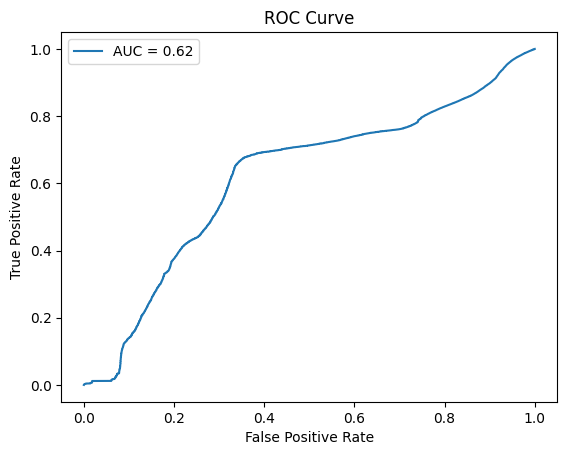

In [ ]:
# Visualization
plt.figure()
fpr, tpr, _ = roc_curve(y_test, hybrid_mse)
roc_auc = roc_auc_score(y_test, hybrid_mse)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

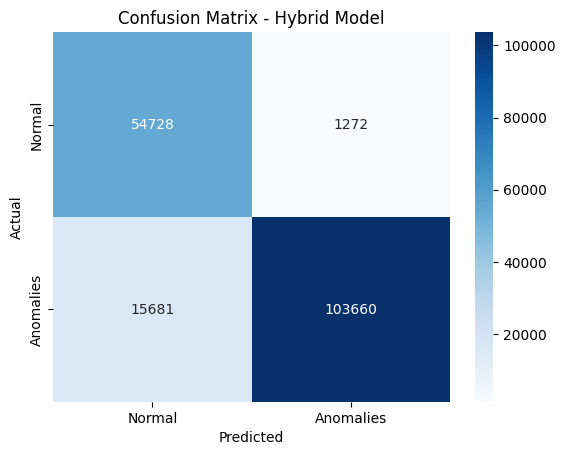

In [ ]:
# Visualization of Confusion Matrix
cm = confusion_matrix(y_test, hybrid_y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomalies"], yticklabels=["Normal", "Anomalies"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()

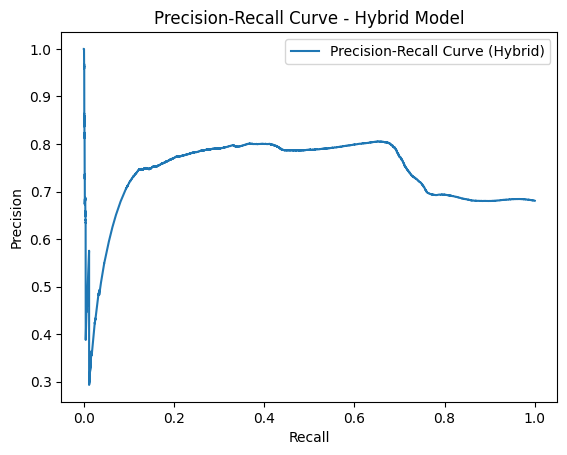

In [ ]:
# Precision-Recall Curve for Hybrid Model
precision, recall, _ = precision_recall_curve(y_test, hybrid_mse)
plt.figure()
plt.plot(recall, precision, label="Precision-Recall Curve (Hybrid)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Hybrid Model")
plt.legend()
plt.show()

In [ ]:
# Evaluation Metrics for Hybrid Model
precision_score, recall_score, f1_score, _ = precision_recall_fscore_support(y_test, hybrid_y_pred, average='binary')
accuracy = accuracy_score(y_test, hybrid_y_pred)
print(f"Hybrid Model Precision: {precision_score:.4f}")
print(f"Hybrid Model Recall: {recall_score:.4f}")
print(f"Hybrid Model F1-Score: {f1_score:.4f}")
print(f"Hybrid Model Accuracy: {accuracy:.4f}")

Hybrid Model Precision: 0.9879
Hybrid Model Recall: 0.8686
Hybrid Model F1-Score: 0.9244
Hybrid Model Accuracy: 0.9033


In [ ]:
# Save Hybrid Model Results
hybrid_results = {
    "Precision": precision_score,
    "Recall": recall_score,
    "F1-Score": f1_score,
    "Accuracy": accuracy
}
hybrid_results_df = pd.DataFrame([hybrid_results])
hybrid_results_df.to_csv("hybrid_model_results.csv", index=False)

In [ ]:
# Save the Random Forest model
import joblib
best_autoencoder.save("optimized_autoencoder.h5")
joblib.dump(best_rf, "optimized_random_forest.pkl")

['optimized_random_forest.pkl']